In [84]:
!pip install fredapi PyPortfolioOpt

#### Importing necessary libraries

In [132]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.optimize import minimize
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.express as px

from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

#### Defining a list of stock tickers

In [86]:
tickers = [    'AAPL',
    'MSFT',
    'META',
    'AMZN',
    'NVDA',
    'GOOGL',
    'HD',
    'ABBV',
    'KO',
    'DIS',
    'T',
    'UPS',
    'LMT',
    'CAT',
    'HSY']


#### Setting up start and end dates for data retrieval

In [87]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 3*365)

#### Retrieving adjusted close prices for each ticker and storing in a DataFrame

In [88]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [89]:
adj_close_df.head(3)

,AAPL,MSFT,META,AMZN,NVDA,GOOGL,HD,ABBV,KO,DIS,T,UPS,LMT,CAT,HSY
Date,,,,,,,,,,,,,,,
2021-02-24,123.201477,228.519150,264.029846,157.976501,144.663940,104.190498,241.675659,96.153336,46.287212,196.868378,17.715794,145.173172,319.091461,208.784332,139.024002
2021-02-25,118.916199,223.102112,254.420059,152.858002,132.775726,100.797501,237.287796,94.950211,45.794300,190.359589,17.263557,142.851379,314.634644,208.174347,139.024002
2021-02-26,119.181580,226.404938,257.346954,154.646500,136.836609,101.095497,240.160355,95.312904,44.717228,188.425888,16.817347,143.141602,306.432220,202.599731,137.215195


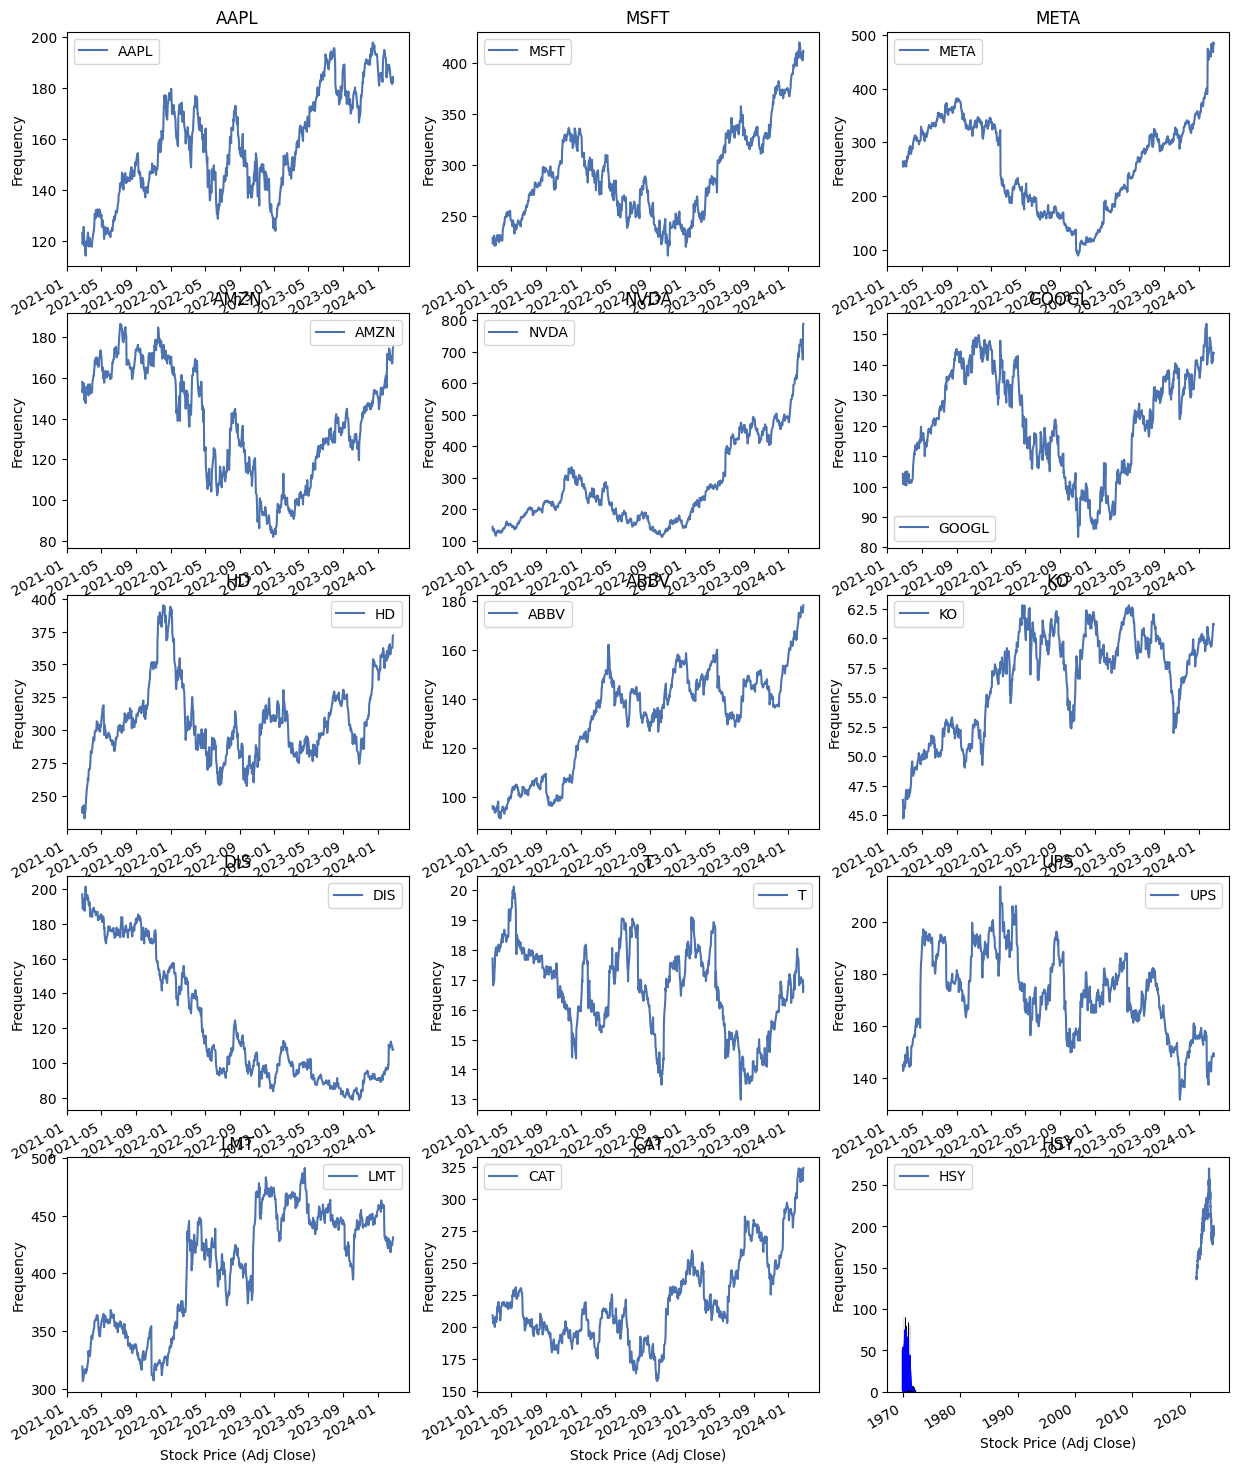

In [90]:
num_rows = 5
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 20))

axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    sns.histplot(adj_close_df[ticker], kde=True, color='blue', bins=30)
    adj_close_df[ticker].plot(ax=ax, label=ticker)
    ax.set_title(ticker)
    ax.set_xlabel('Stock Price (Adj Close)')
    ax.set_ylabel('Frequency')
    ax.legend()

for i in range(len(tickers), num_rows * num_cols):
    axes[i].axis('off')


#### Calculating log returns

In [91]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns

,AAPL,MSFT,META,AMZN,NVDA,GOOGL,HD,ABBV,KO,DIS,T,UPS,LMT,CAT,HSY
Date,,,,,,,,,,,,,,,
2021-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-25,-0.035402,-0.023990,-0.037075,-0.032937,-0.085752,-0.033107,-0.018323,-0.012592,-0.010706,-0.033621,-0.025859,-0.016123,-0.014066,-0.002926,0.000000
2021-02-26,0.002229,0.014696,0.011439,0.011632,0.030126,0.002952,0.012033,0.003813,-0.023801,-0.010210,-0.026187,0.002030,-0.026416,-0.027144,-0.013096
2021-03-01,0.052451,0.019433,0.027905,0.017057,0.009236,0.023342,0.012617,0.006199,0.018405,0.030938,0.007145,0.022801,0.009703,0.017813,-0.003163
2021-03-02,-0.021115,-0.013041,-0.022562,-0.016540,-0.031969,-0.002506,-0.005097,-0.005179,0.004000,-0.005348,0.004617,-0.000620,0.015237,-0.018091,0.001101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-16,-0.008466,-0.006168,-0.022375,-0.001709,-0.000620,-0.015885,0.003511,0.005084,-0.000168,-0.007588,-0.007046,0.020834,0.002243,-0.003597,-0.000262
2024-02-20,-0.004122,-0.003148,-0.003322,-0.014439,-0.044508,0.004261,0.000607,-0.009852,0.021818,-0.019545,-0.003542,0.001549,0.000471,-0.025707,0.012528
2024-02-21,0.004177,-0.001516,-0.006856,0.008997,-0.028923,0.010082,0.004293,-0.003477,0.008857,-0.016305,0.005308,-0.002492,0.007701,0.010779,-0.005595


#### Counting NaN values in log returns

In [92]:
log_returns.isna().sum()

AAPL     1
MSFT     1
META     1
AMZN     1
NVDA     1
GOOGL    1
HD       1
ABBV     1
KO       1
DIS      1
T        1
UPS      1
LMT      1
CAT      1
HSY      1
dtype: int64

#### Calculating mean log returns

In [93]:
log_returns.mean()

AAPL     0.000521
MSFT     0.000776
META     0.000804
AMZN     0.000136
NVDA     0.002248
GOOGL    0.000429
HD       0.000572
ABBV     0.000817
KO       0.000370
DIS     -0.000799
T       -0.000070
UPS      0.000031
LMT      0.000399
CAT      0.000582
HSY      0.000441
dtype: float64

#### Dropping NaN values from log returns

In [94]:
log_returns.dropna(inplace=True)

#### Calculating covariance matrix of log returns

In [95]:
cov_matrix = log_returns.cov() * 252
cov_matrix

,AAPL,MSFT,META,AMZN,NVDA,GOOGL,HD,ABBV,KO,DIS,T,UPS,LMT,CAT,HSY
AAPL,0.074610,0.054716,0.070410,0.062166,0.091276,0.058392,0.033832,0.009382,0.016197,0.037880,0.013884,0.032212,0.010636,0.023785,0.011451
MSFT,0.054716,0.076222,0.077718,0.069939,0.099984,0.063362,0.033068,0.008504,0.014896,0.036754,0.007209,0.030892,0.006326,0.018897,0.010000
META,0.070410,0.077718,0.241057,0.109267,0.133840,0.095098,0.046138,0.003013,0.011442,0.057279,0.015961,0.043309,0.003941,0.023510,0.004312
AMZN,0.062166,0.069939,0.109267,0.141217,0.119836,0.078995,0.042868,0.007155,0.013674,0.054617,0.015751,0.040440,0.003554,0.025641,0.006075
NVDA,0.091276,0.099984,0.133840,0.119836,0.280319,0.101767,0.053985,0.008797,0.013278,0.066289,0.006405,0.054207,0.000475,0.045762,0.002410
GOOGL,0.058392,0.063362,0.095098,0.078995,0.101767,0.098925,0.033454,0.008396,0.013602,0.040973,0.011735,0.032579,0.004965,0.023008,0.007111
HD,0.033832,0.033068,0.046138,0.042868,0.053985,0.033454,0.060932,0.010334,0.015596,0.031550,0.013484,0.032297,0.009200,0.025727,0.011057
ABBV,0.009382,0.008504,0.003013,0.007155,0.008797,0.008396,0.010334,0.041345,0.012210,0.007321,0.009297,0.011978,0.007728,0.011699,0.008470
KO,0.016197,0.014896,0.011442,0.013674,0.013278,0.013602,0.015596,0.012210,0.025408,0.013009,0.014365,0.014587,0.011509,0.011908,0.017814
DIS,0.037880,0.036754,0.057279,0.054617,0.066289,0.040973,0.031550,0.007321,0.013009,0.092155,0.021826,0.033043,0.009066,0.033632,0.007683


#### Heatmap of correlation between log returns of all assets

<Axes: >

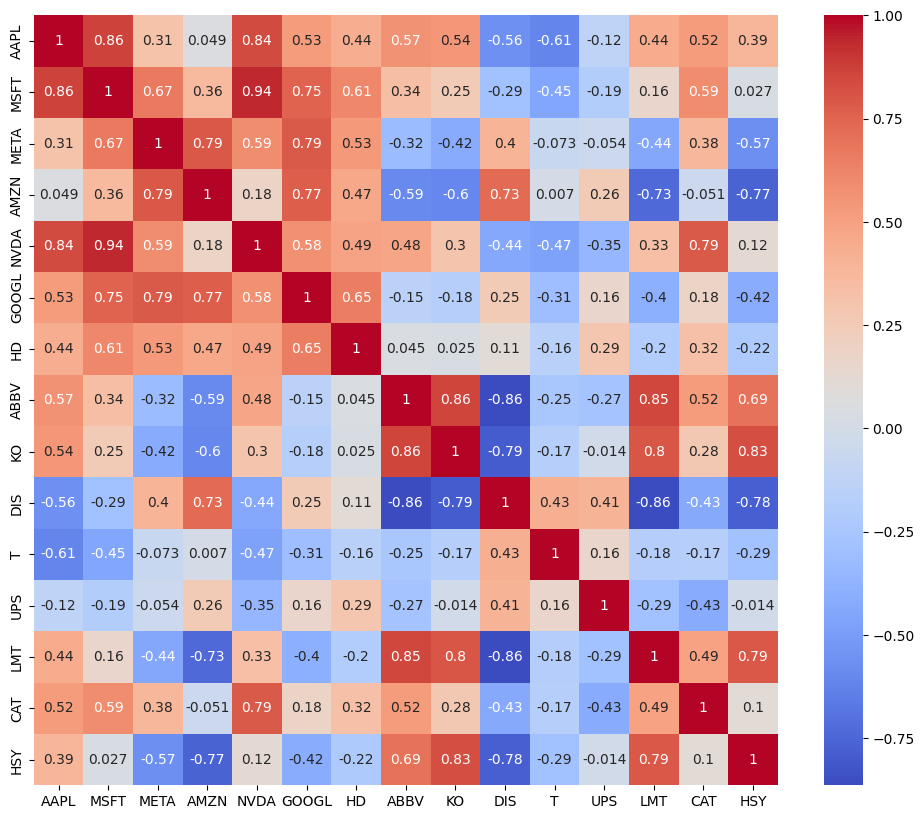

In [96]:
import matplotlib.pyplot as plt

corr_matrix = adj_close_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

#### Defining a function to calculate standard deviation

In [118]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

#### Defining a function to calculate expected annualized returns

In [119]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights*252)

#### Defining a function to calculate the sharpe ratio

In [120]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

#### Retrieving risk-free rate from FRED API

In [114]:
from fredapi import Fred

fred = Fred(api_key='37d707ea29d05517c0f3f400b23644bb')
treasury_rate_10y = fred.get_series_latest_release('GS10')/100
risk_free_rate = treasury_rate_10y[-1]
risk_free_rate

0.0406

#### Defining a function to calculate negative Sharpe ratio

In [121]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Defining constraints and bounds for optimization

In [102]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

#### Setting initial weights for optimization

In [103]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
initial_weights

array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667,
       0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667])

#### Optimizing portfolio weights

In [157]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x


#### Printing optimal weights for each ticker

In [159]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
AAPL: 0.0000
MSFT: 0.0000
META: 0.0000
AMZN: 0.0000
NVDA: 0.2706
GOOGL: 0.0000
HD: 0.0000
ABBV: 0.5000
KO: 0.0000
DIS: 0.0000
T: 0.0000
UPS: 0.0000
LMT: 0.0738
CAT: 0.0000
HSY: 0.1556


#### Calculating expected annual return, volatility, and Sharpe ratio of the optimal portfolio

In [152]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 0.2810
Expected Volatility: 0.1916
Sharpe Ratio: 1.2546


#### Plotting Volatility vs Returns with Sharpe Ratio

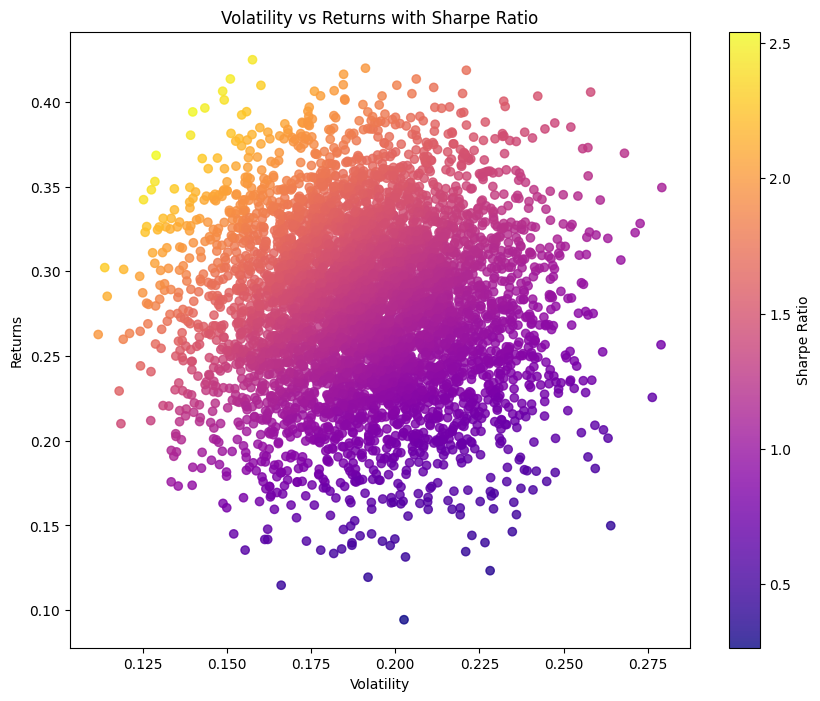

In [154]:
num_samples = 5000

volatility_samples = np.random.normal(optimal_portfolio_volatility, 0.025, num_samples)
returns_samples = np.random.normal(optimal_portfolio_return, 0.05, num_samples)
sharpe_ratio_samples = (returns_samples - risk_free_rate) / volatility_samples

plt.figure(figsize=(10,8))
plt.scatter(volatility_samples, returns_samples, c=sharpe_ratio_samples, cmap='plasma', alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.title('Volatility vs Returns with Sharpe Ratio')
plt.show()

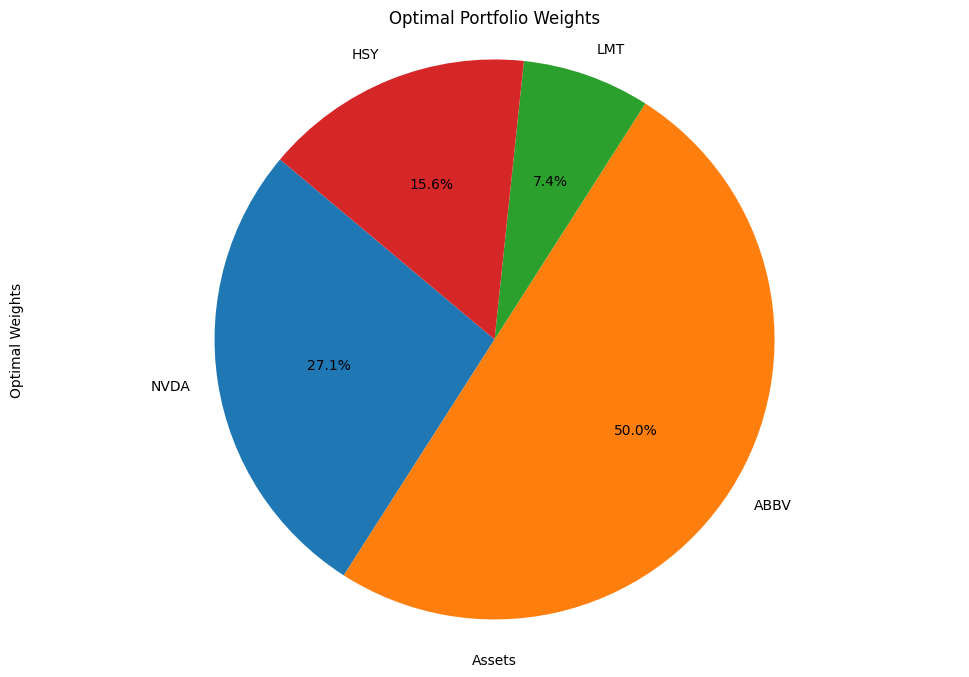

In [ ]:
filtered_weights = [w for w in optimal_weights if w > 0.01]
filtered_tickers = [tickers[i] for i, w in enumerate(optimal_weights) if w > 0.01]

plt.figure(figsize=(12, 8))
plt.pie(filtered_weights, labels = filtered_tickers, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

#### Medium risk goal - Choosing the best method to maximize the weights for each asset

In [127]:
methods = ['SLSQP', 'CG', 'Nelder-Mead', 'L-BFGS-B', 'trust-constr', 'Powell']
results = {}

for method in methods:
    result = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method=method, constraints=constraints, bounds=bounds)
    optimal_weights_loop = result.x
    portfolio_return = expected_return(optimal_weights_loop, log_returns)
    portfolio_volatility = standard_deviation(optimal_weights_loop, cov_matrix)
    optimal_sharpe = sharpe_ratio(optimal_weights_loop, log_returns, cov_matrix, risk_free_rate)

    results[method] = optimal_sharpe

for method, sharpe in results.items():
    print(f"Sharpe ratio using {method}: {sharpe}")

best_method = max(results, key=results.get)
print(f"\nBest method for portfolio optimization: {best_method}")

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method CG cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method Nelder-Mead cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of u

Sharpe ratio using SLSQP: 1.2545852330375347
Sharpe ratio using CG: 2.2029691743728645
Sharpe ratio using Nelder-Mead: 1.2559519066486697
Sharpe ratio using L-BFGS-B: 1.3054777325432874
Sharpe ratio using trust-constr: 0.9953762480689964
Sharpe ratio using Powell: 1.305262320980834

Best method for portfolio optimization: CG


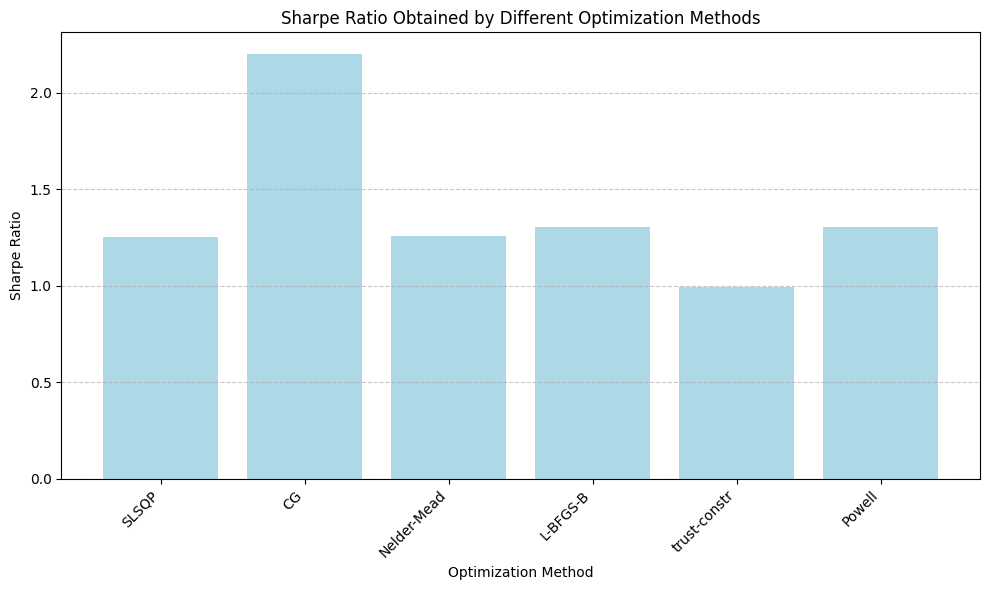

In [138]:
methods = list(results.keys())
ratios = list(results.values())

plt.figure(figsize=(10, 6))
plt.bar(methods, ratios, color='lightblue')
plt.xlabel('Optimization Method')
plt.ylabel('Sharpe Ratio')
plt.title('Sharpe Ratio Obtained by Different Optimization Methods')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Re-Computing Sharpe ratios using the most optimal (CG) method

In [160]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='CG', constraints=constraints, bounds=bounds)
optimal_weights = optimized_results.x

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:576: RuntimeWarning: Method CG cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:580: RuntimeWarning: Method CG cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,


In [165]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, y):
    print(f"{ticker}: {weight:.4f}")

Optimal Weights:
AAPL: -24.2850
MSFT: 35.7011
META: 19.6348
AMZN: -34.3015
NVDA: 67.3779
GOOGL: -23.7280
HD: 38.1770
ABBV: 92.0105
KO: 6.0820
DIS: -103.7393
T: -3.5592
UPS: -41.6266
LMT: 23.9938
CAT: 32.7948
HSY: 53.1260


In [162]:
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.2f}%")
print(f"Expected Volatility: {optimal_portfolio_volatility:.2f}%")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Expected Annual Return: 101.00%
Expected Volatility: 45.83%
Sharpe Ratio: 2.2030


#### Generating samples for plotting Volatility vs Returns with Sharpe Ratio

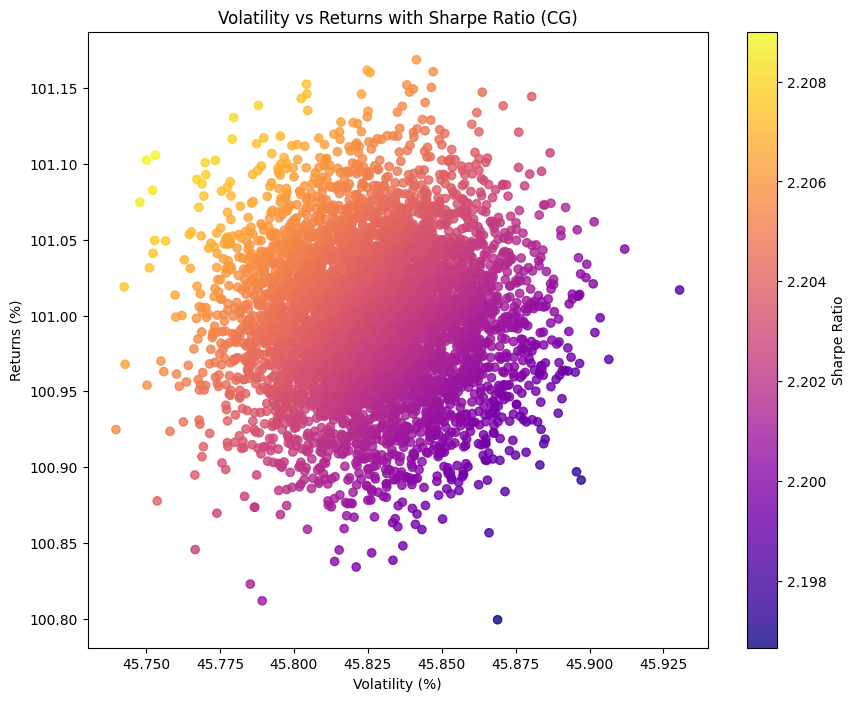

In [169]:
num_samples = 5000

volatility_samples = np.random.normal(optimal_portfolio_volatility, 0.025, num_samples)
returns_samples = np.random.normal(optimal_portfolio_return, 0.05, num_samples)
sharpe_ratio_samples = (returns_samples - risk_free_rate) / volatility_samples

plt.figure(figsize=(10,8))
plt.scatter(volatility_samples, returns_samples, c=sharpe_ratio_samples, cmap='plasma', alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('Sharpe Ratio')
plt.xlabel('Volatility (%)')
plt.ylabel('Returns (%)')
plt.title('Volatility vs Returns with Sharpe Ratio (CG)')
plt.show()

#### Plotting Volatility vs Returns with Sharpe Ratio

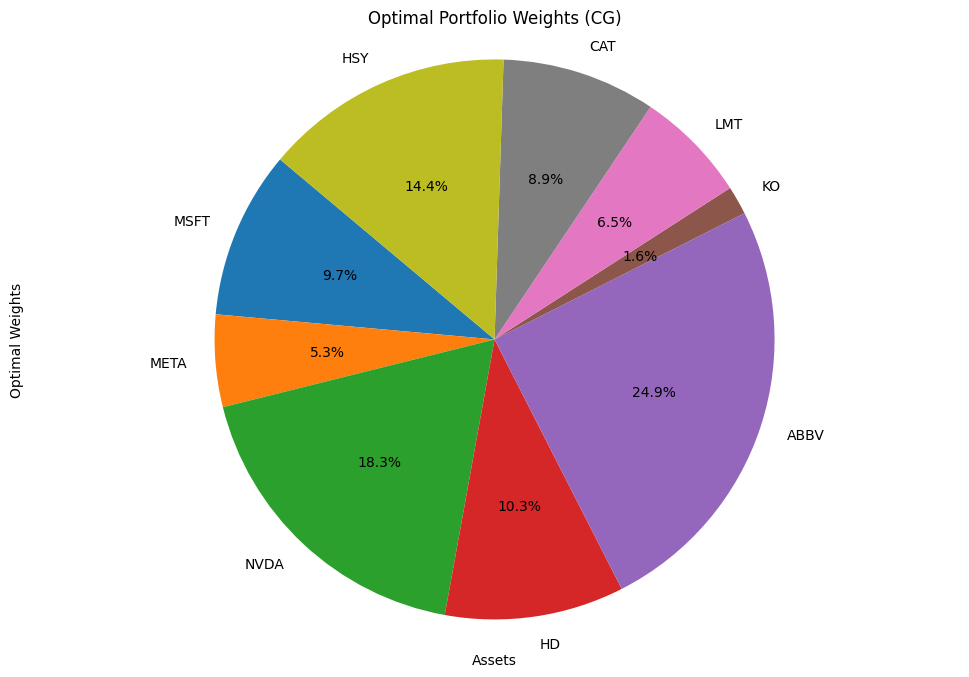

In [170]:
filtered_weights = [w for w in optimal_weights if w > 0.01]
filtered_tickers = [tickers[i] for i, w in enumerate(optimal_weights) if w > 0.01]

plt.figure(figsize=(12, 8))
plt.pie(filtered_weights, labels = filtered_tickers, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights (CG)')

plt.show()

## Black-Litterman Implementation

In [171]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats
from fredapi import Fred
from pypfopt import black_litterman


avg_returns = {}
for ticker in tickers:
    prices = adj_close_df[ticker]
    returns = prices.pct_change().dropna()  # Calculate daily returns, dropping NA values
    avg_returns[ticker] = returns.mean() * 252


print("Average Returns for Each Stock:")
print(avg_returns)


# # Download market index data (e.g., S&P 500)
# market_index = '^GSPC'  # S&P 500 index ticker
# market_data = yf.download(market_index, start=start_date, end=end_date)['Adj Close']

# # Calculate excess returns for stocks and market index
# excess_returns = adj_close_df.pct_change() - risk_free_rate
# market_excess_returns = market_data.pct_change() - risk_free_rate

# # Perform linear regression for each stock
# regression_results = {}
# for ticker in tickers:
#     excess_returns_ticker = excess_returns[ticker].dropna()
#     excess_returns_market = market_excess_returns.dropna()

#     slope, intercept, r_value, p_value, std_err = stats.linregress(excess_returns_market, excess_returns_ticker)
#     regression_results[ticker] = {'slope': slope, 'intercept': intercept}
# print(regression_results)
# # Calculate expected returns using CAPM
# expected_returns = {}
# for ticker, result in regression_results.items():
#     beta = result['slope']
#     expected_returns[ticker] = risk_free_rate + beta * (market_excess_returns.mean())
# print(expected_returns)
# Calculate deviations from market-implied returns
# market_prior_returns = black_litterman.market_implied_prior_returns(tickers, market_data, risk_free_rate)
# views = {}
# for ticker, expected_return in expected_returns.items():
#     view = expected_return - market_prior_returns[ticker]
#     views[ticker] = view

# print("Regression-Derived Expected Returns:")
# print(expected_returns)
# print("\nViews (Deviation from Market Prior Returns):")
# print(views)


Average Returns for Each Stock:
{'AAPL': 0.16867715121807583, 'MSFT': 0.23380511205191054, 'META': 0.3216103003291651, 'AMZN': 0.1046655217174291, 'NVDA': 0.7084330199042824, 'GOOGL': 0.15742032409548745, 'HD': 0.1745252602781442, 'ABBV': 0.22664914702158076, 'KO': 0.10602214793136575, 'DIS': -0.15550341178051305, 'T': 0.013903671446473281, 'UPS': 0.04468551072478345, 'LMT': 0.12390911158179292, 'CAT': 0.1889755715484443, 'HSY': 0.1278795167689011}


In [172]:
market_prices = yf.download("SPY", start='2018-01-01', end='2023-02-28')["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2018-01-02    243.072250
2018-01-03    244.609726
2018-01-04    245.640793
2018-01-05    247.277679
2018-01-08    247.729904
Name: Adj Close, dtype: float64

In [173]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'AAPL': 2818455633920,
 'MSFT': 3049006825472,
 'META': 1233990975488,
 'AMZN': 1817691160576,
 'NVDA': 1970424905728,
 'GOOGL': 1797455872000,
 'HD': 370197659648,
 'ABBV': 314590625792,
 'KO': 263922548736,
 'DIS': 197627478016,
 'T': 120120328192,
 'UPS': 126729822208,
 'LMT': 104177131520,
 'CAT': 161738227712,
 'HSY': 39531630592}

In [174]:
S = risk_models.CovarianceShrinkage(adj_close_df).ledoit_wolf()

delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.090707040423512

<Axes: >

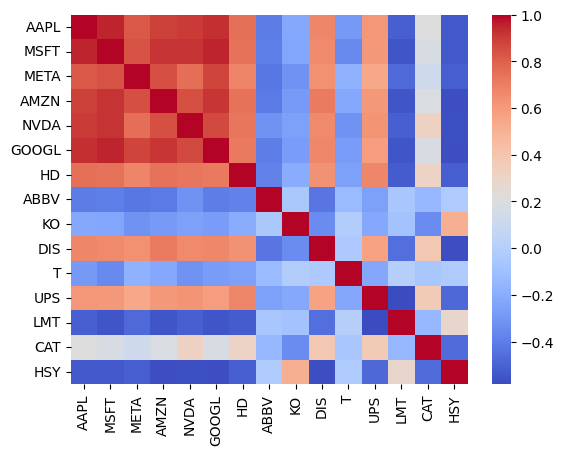

In [175]:
sns.heatmap(S.corr(), cmap='coolwarm')

In [ ]:
# market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
# market_prior
# views = {}
# for ticker, expected_return in expected_returns.items():
#     view = expected_return - market_prior[ticker]
#     views[ticker] = view

# print("Regression-Derived Expected Returns:")
# print(expected_returns)
# print("\nViews (Deviation from Market Prior Returns):")
# print(views)

In [ ]:
# market_prior.plot.barh(figsize=(10,5));

[*********************100%%**********************]  1 of 1 completed


Investor Views (Deviation from Market Prior Returns):
{'AAPL': 0.019602099905377784, 'MSFT': 0.07667159834838222, 'META': 0.101533482972547, 'AMZN': -0.08664765155912113, 'NVDA': 0.43820437573311377, 'GOOGL': -0.010233928471221537, 'HD': 0.076860523580508, 'ABBV': 0.18842325288463568, 'KO': 0.05657853359122736, 'DIS': -0.2666527962835039, 'T': -0.03045715250237896, 'UPS': -0.04936111872686828, 'LMT': 0.0910266950526808, 'CAT': 0.11556885387588735, 'HSY': 0.09130582333173864}


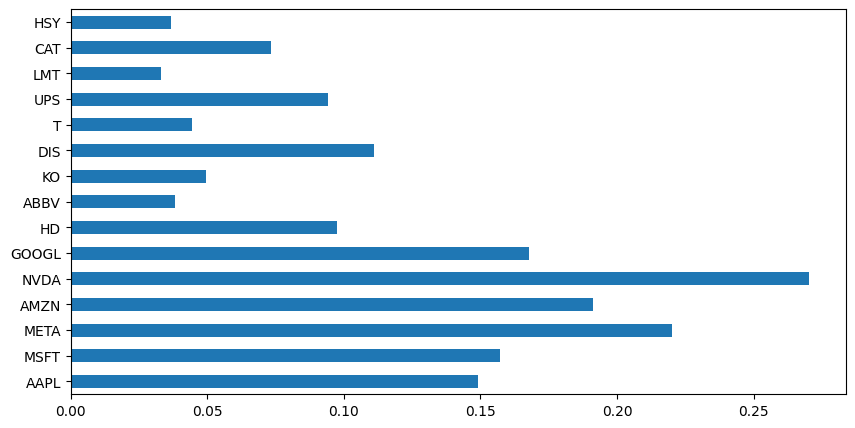

In [176]:
#You don't have to provide views on all the assets
viewdict = {
    'AAPL':0.10,
    'MSFT':0.10,
    'META':0.05,
    'AMZN':0.30,
    'NVDA':0.02,
    'GOOGL':0.01,
    'HD':0.16,
    'ABBV':0.07,
    'KO':0.01,
    'DIS':-0.23,
    'T':0.16,
    'UPS':0.10,
    'LMT':-0.09,
    'CAT':0.30,
    'HSY':-0.26
}
tickers = list(avg_returns.keys())  # Get list of tickers
market_data = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']  # Download S&P 500 data as market proxy
risk_free_rate = Fred(api_key='37d707ea29d05517c0f3f400b23644bb').get_series_latest_release('DGS10')[-1] / 100  # 10-year treasury yield
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)

# Calculate deviations from market-implied returns
views = {}
for ticker, avg_return in avg_returns.items():
    view = avg_return - market_prior[ticker]
    views[ticker] = view

print("Investor Views (Deviation from Market Prior Returns):")
print(views)
market_prior.plot.barh(figsize=(10,5));
viewdict= views
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [177]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3),
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25)
]

In [178]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225, 0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005]


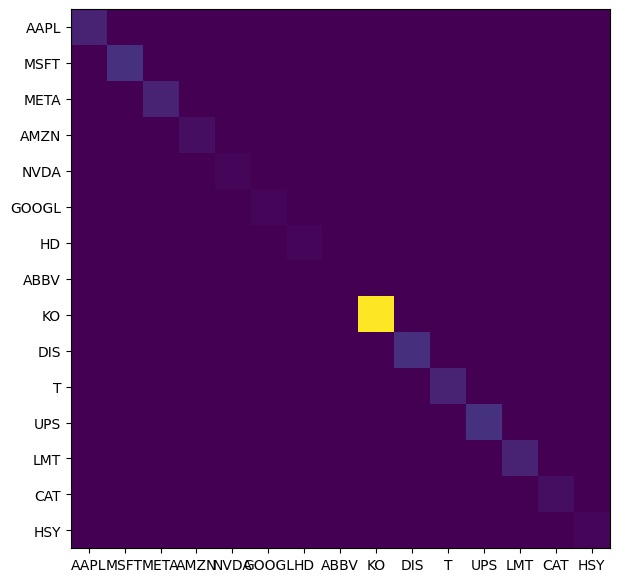

In [179]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
# We are using the shortcut to automatically compute market-implied prior
# bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views=viewdict, omega=omega)

In [180]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AAPL     0.062274
MSFT     0.078737
META     0.070263
AMZN     0.018196
NVDA     0.205954
GOOGL    0.049662
HD       0.055407
ABBV     0.107517
KO       0.052519
DIS     -0.078892
T       -0.005040
UPS      0.009646
LMT      0.063149
CAT      0.066341
HSY      0.060591
dtype: float64

In [183]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AAPL,0.149075,0.062274,0.019602
MSFT,0.157134,0.078737,0.076672
META,0.220077,0.070263,0.101533
AMZN,0.191313,0.018196,-0.086648
NVDA,0.270229,0.205954,0.438204
GOOGL,0.167654,0.049662,-0.010234
HD,0.097665,0.055407,0.076861
ABBV,0.038226,0.107517,0.188423
KO,0.049444,0.052519,0.056579
DIS,0.111149,-0.078892,-0.266653


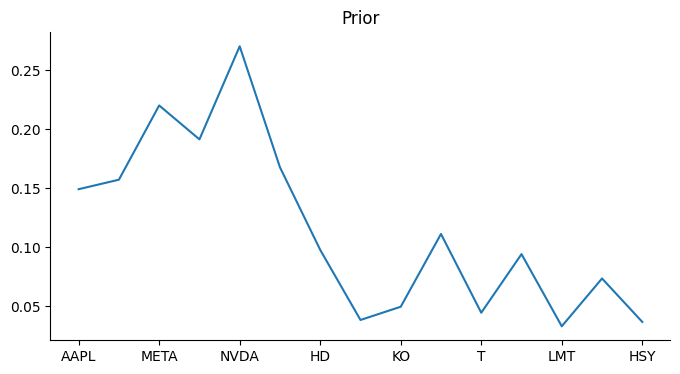

In [182]:
# @title Prior

from matplotlib import pyplot as plt
rets_df['Prior'].plot(kind='line', figsize=(8, 4), title='Prior')
plt.gca().spines[['top', 'right']].set_visible(False)

<Axes: >

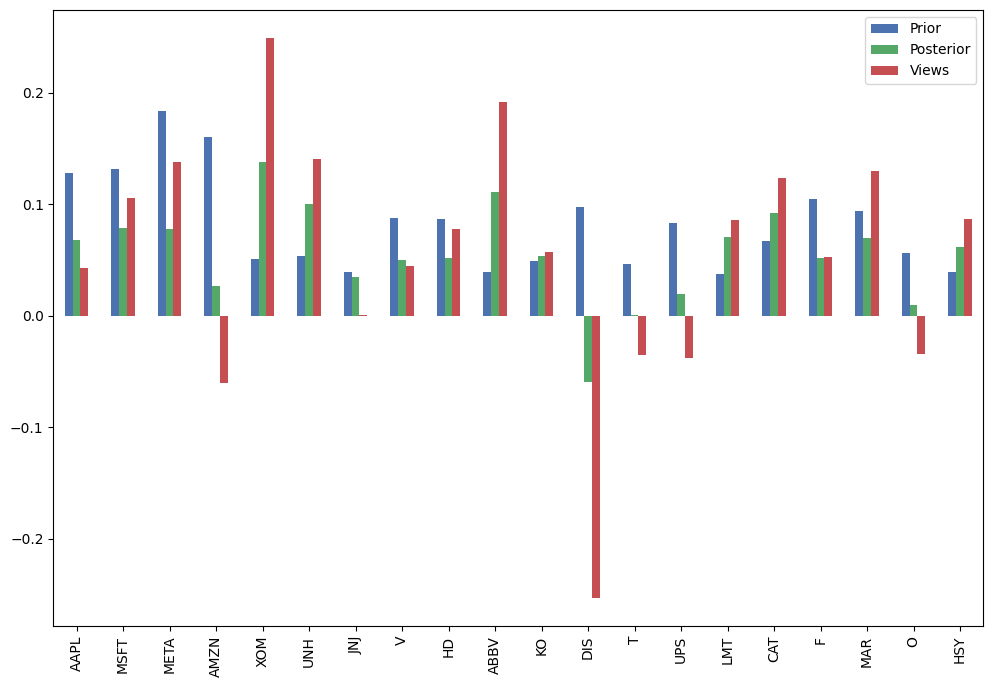

In [ ]:
rets_df.plot.bar(figsize=(12,8))

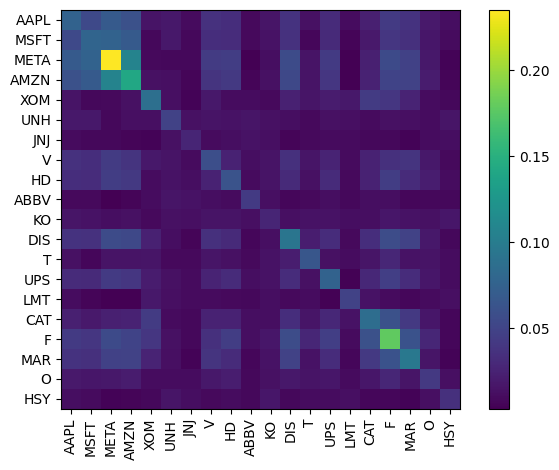

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AAPL', 0.05197),
             ('MSFT', 0.0713),
             ('META', 0.05924),
             ('AMZN', 0.0),
             ('XOM', 0.16585),
             ('UNH', 0.11408),
             ('JNJ', 0.01394),
             ('V', 0.02703),
             ('HD', 0.03085),
             ('ABBV', 0.13452),
             ('KO', 0.04205),
             ('DIS', 0.0),
             ('T', 0.0),
             ('UPS', 0.0),
             ('LMT', 0.06977),
             ('CAT', 0.09015),
             ('F', 0.01851),
             ('MAR', 0.05384),
             ('O', 0.0),
             ('HSY', 0.0569)])

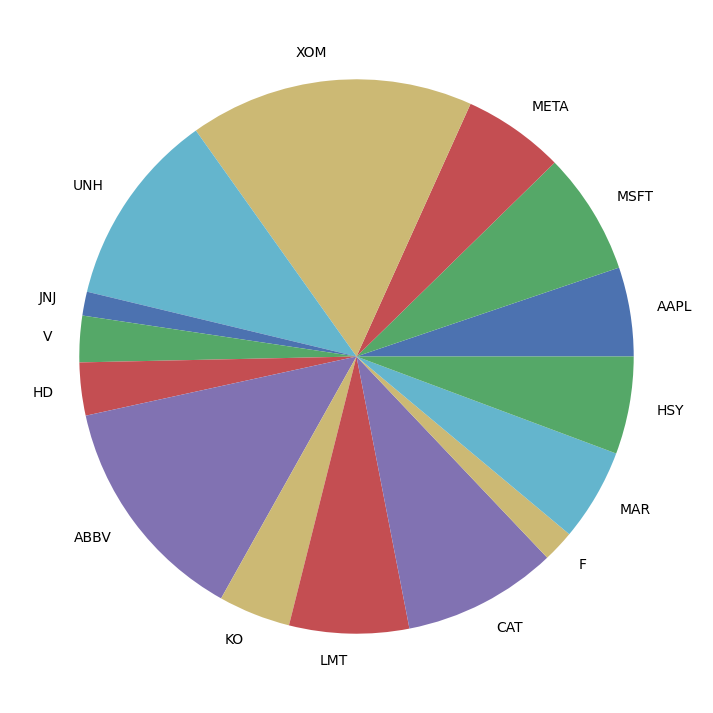

In [ ]:
pd.Series(weights).plot.pie(figsize=(9,9));

Expected annual return: 9.0%
Annual volatility: 14.9%
Sharpe Ratio: 0.47


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.09012897690478996, 0.14867430139566087, 0.4716953518292214)

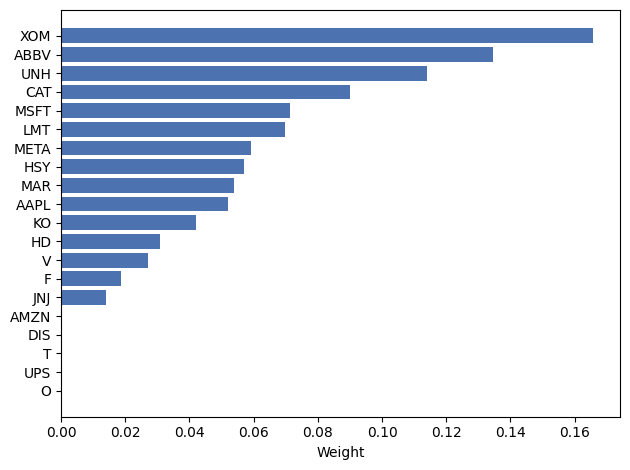

In [ ]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.009)